In [1]:
import os
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel

# %%
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


Using seed: 1748150978


100%|██████████| 16/16 [00:09<00:00,  1.78it/s]


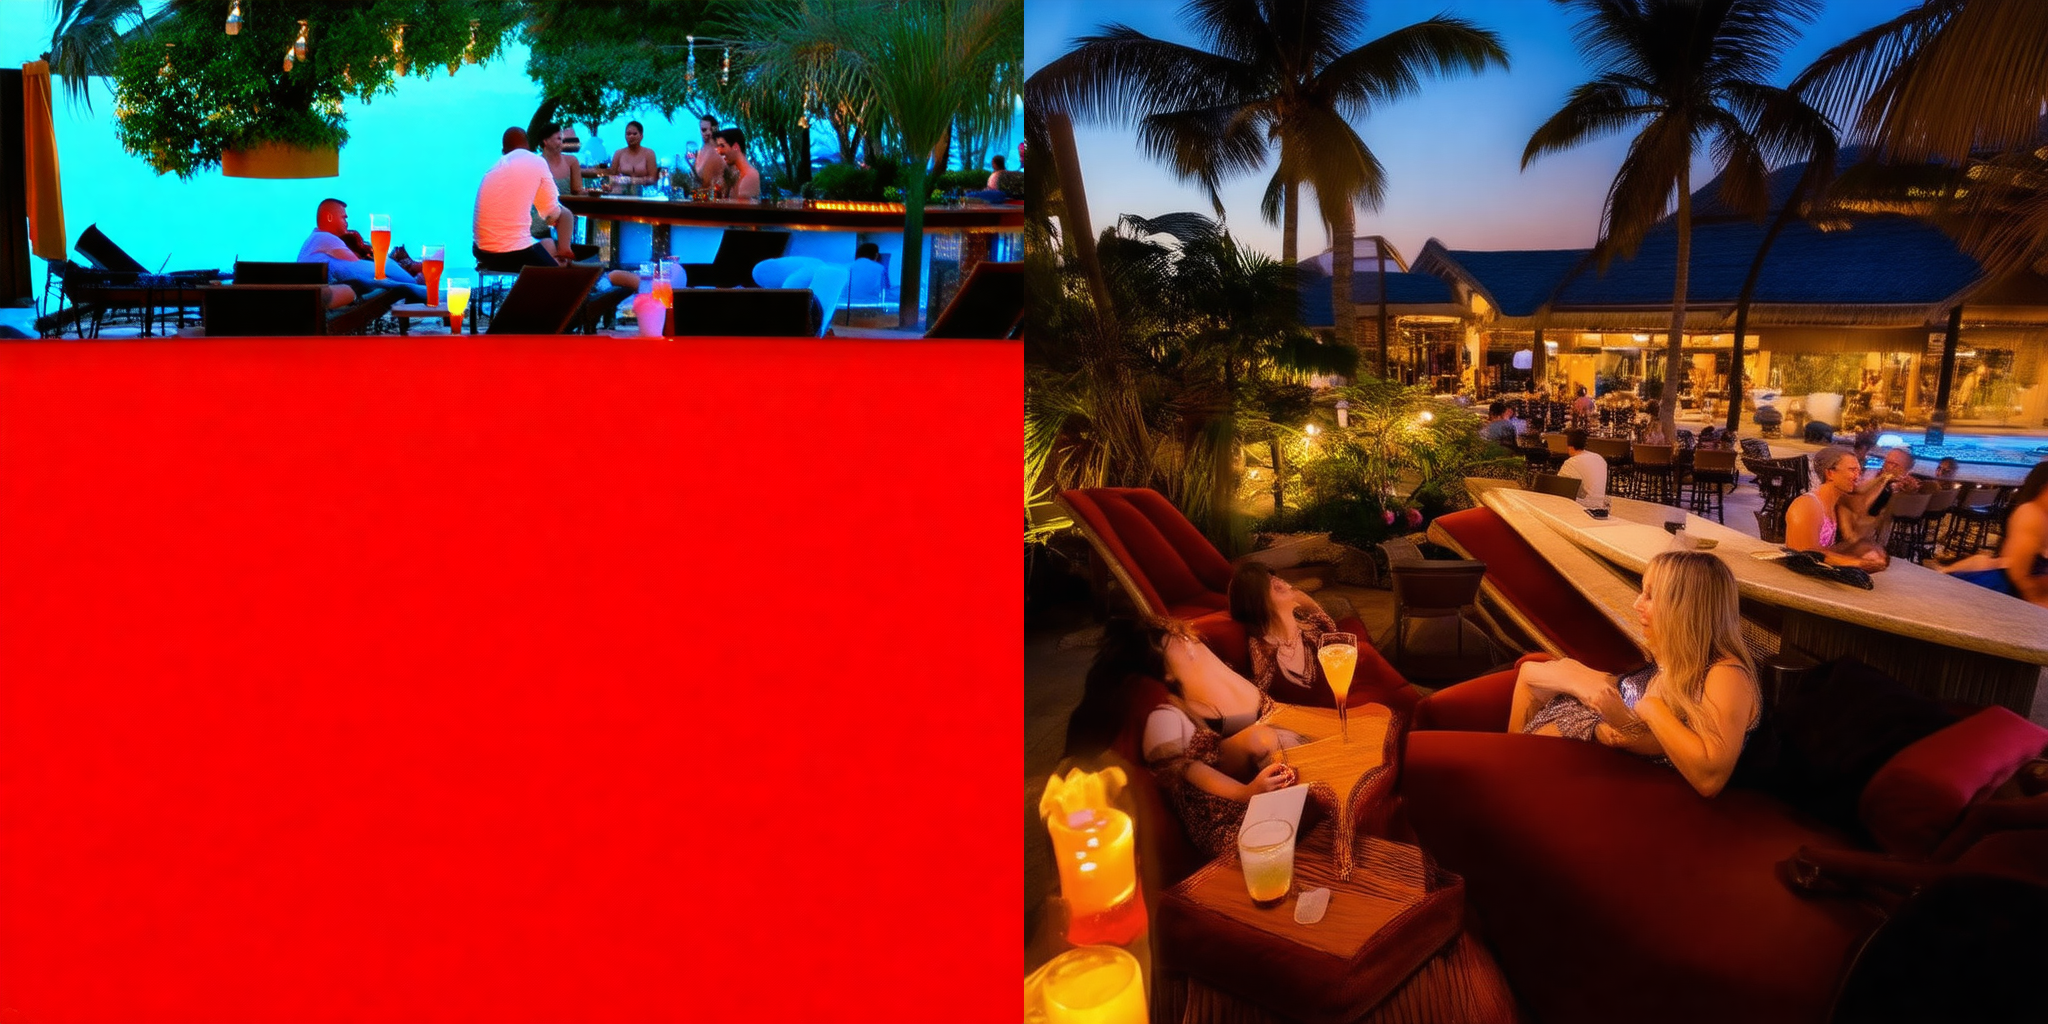

In [ ]:
positive_prompt = "A luxury resort's outdoor leisure area in the evening, with guests enjoying drinks at an outdoor bar, and others relaxing on sun loungers while some people swim in the open-air leisure space."
negative_prompt = "swimming pool"
import time
seed = int(time.time())
print(f"Using seed: {seed}")    

for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt)), 
        len(pipe.tokenizer_2.tokenize(negative_prompt)),
        len(pipe.tokenizer_3.tokenize(negative_prompt))
    ]) + 1 


image_ours = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=5,
    guidance_scale=7, 
    negative_offset=-6,
    clamp_value=15, 
    return_steps=1,
    generator=torch.manual_seed(seed),  
).images
negative_guidance_scales = pipe.negative_guidance_scales
weight_maps = pipe.weight_maps
image_vanilla = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    guidance_scale=7, 
    return_steps=1,
    vanilla=True,
    generator=torch.manual_seed(seed),
).images

Image.fromarray(
            np.concatenate(
                [np.array(image_ours[-1]), np.array(image_vanilla[-1])], axis=1
            ) 
 ) 

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/transformers/models/owlv2/processing_owlv2.py:213: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


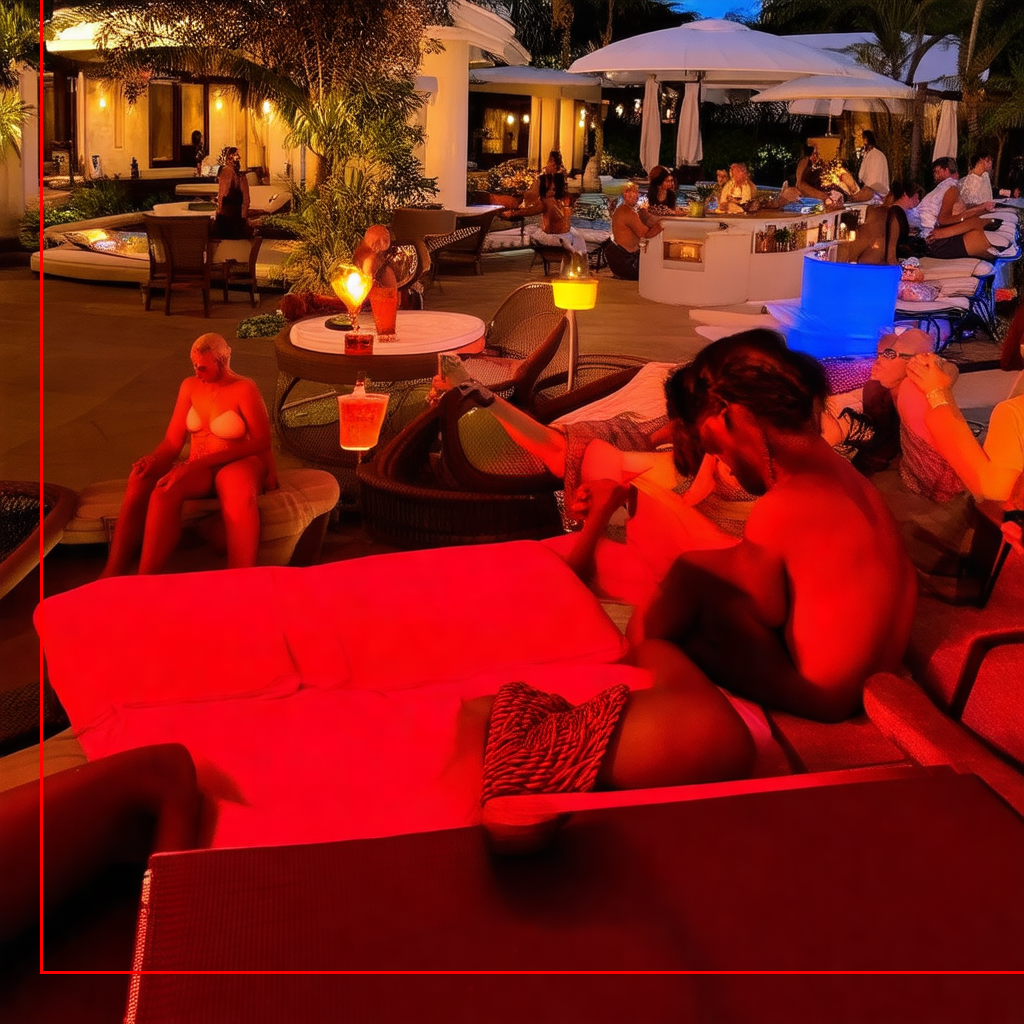

In [3]:
import requests
from PIL import Image
import torch
from PIL import ImageDraw

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-large-patch14-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-large-patch14-ensemble").to("cuda")

image = image_ours[-1]
texts = [["swimming pool", "A luxury resort's outdoor leisure area in the evening."]]
inputs = processor(text=texts, images=image, return_tensors="pt").to("cuda")

with torch.no_grad():
  outputs = model(**inputs) 

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
max_score_index = scores.argmax()

box = boxes[max_score_index].cpu().numpy()
image = image_ours[-1].copy()
draw = ImageDraw.Draw(image)
draw.rectangle(box, outline="red", width=3)
image

In [4]:
frames = []
for i in range(len(image_ours)):
    frame = np.concatenate(
        [np.array(image_ours[i]), np.array(image_vanilla[i])], axis=1
    )
    frames.append(Image.fromarray(frame))

In [5]:
# save as a video
import imageio
imageio.mimwrite(
    "sd3_ours_vs_vanilla.mp4",
    frames,
    fps=2,
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[rawvideo @ 0x2b924080] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [6]:
pipe.scheduler.timesteps

tensor([1000.0000,  976.8171,  951.3798,  923.3425,  892.2853,  857.6923,
         818.9233,  775.1736,  725.4174,  668.3267,  602.1506,  524.5327,
         432.2251,  320.6215,  182.9653,    8.9286], device='cuda:0')

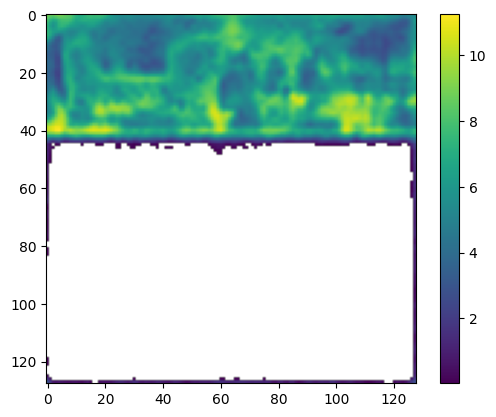

In [ ]:
import pylab
pylab.imshow(weight_maps[6].mean(0).mean(0).cpu().float().numpy())
pylab.colorbar()